In [1]:
import os

import models
from models import manager

from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf


import importlib
importlib.reload(models.manager)


sku_manager = manager.SkuManager()

In [2]:

def negative_sampling(l):
    '''
    negative sampling, input number of classes, output function to do negative sampling
    
    input:
    ---------
    l: int
        number of classes
    
    output:
    ---------
    sampling: function of sample
    '''
    def sampling(rowData):
        rowData = np.array(rowData)
        negative_sample = np.random.choice(l)
        while negative_sample in rowData:
            negative_sample = np.random.choice(l)
        return negative_sample
    return sampling


In [3]:
from sklearn.externals import joblib
user_encoder_v2 = joblib.load('./models/user_encoder.pkl')


C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
X = np.load('./data/recommendation_X.npy') # 加载数据，第一列是user label，第二列是sku label
y = np.load('./data/recommendation_Y.npy') # 拟合Y，1代表推荐，0代表不推荐

In [5]:
# 将user和sku数据分离
# 划分训练测试集

from sklearn.model_selection import train_test_split

X = np.array(X, dtype=int)
y = np.array(y).reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=112)

x_user_train = x_train[:, 0].reshape(-1,1)
x_sku_train = x_train[:, 1].reshape(-1,1)

x_user_test = x_test[:, 0].reshape(-1,1)
x_sku_test = x_test[:, 1].reshape(-1,1)

In [6]:
def build_seq2vec(num, embedding_dim, name, path=False, trainable=True):
    '''
    创建sequence2vector模型
    
    input：
    -----------
    num: int
            用户或产品数量
    embedding_dim: int
            vector维数
    name: str
            模型名字
    path: str
            embedding预训练weights存储位置
    
            
    output:
    -----------
    model: keras.models.Model object
            sequence2vector模型
    
    '''
    input_ = Input(shape=(1,))
    output = Embedding(num, embedding_dim, trainable=trainable)(input_)
    model = Model(inputs=input_, outputs=output, name=name)
    if path:
        model.load_weights(path)
    return model

In [7]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Embedding, Input, Lambda, Concatenate, Dense, Flatten, Reshape
from tensorflow.keras import backend as K

num_user = len(user_encoder_v2.classes_) # 用户数量
num_sku = sku_manager.get_num_sku() + 1 # 产品数量
path = './models/5_gram_sku2vec_v2.h5' # 预训练权重位置

sku2vec = build_seq2vec(num_sku, 100, path=path, name='sku2vec') # sku 2 vector
sku2vec.load_weights('./models/5_gram_sku2vec_v2.h5') # 加载预训练权重

user2vec_1 = build_seq2vec(num_user, 100, name='user2vec_1') # 创建user2vector模型，提取user的第一个偏好
user2vec_2 = build_seq2vec(num_user, 100, name='user2vec_2') # 创建user2vector模型，提取user的第二个偏好
user2vec_3 = build_seq2vec(num_user, 100, name='user2vec_3') # 创建user2vector模型，提取user的第三个偏好

concat_layer = Concatenate(axis=-1, name='concat') # 将user向量拼接在一起
dense_output = Dense(1, activation='sigmoid', name = 'dense_output') # 最终输出层

recommen_sku = Input(shape=(1))
recommen_user = Input(shape=(1))

sku_vec = sku2vec(recommen_sku)
user_vec1 = user2vec_1(recommen_user)
user_vec2 = user2vec_2(recommen_user)
user_vec3 = user2vec_3(recommen_user)

interest_diff_1 = Flatten()( Lambda(lambda x: K.abs(x[0] - x[1]), name='diff1')([sku_vec, user_vec1])) # user偏好与sku做差
interest_diff_2 = Flatten()( Lambda(lambda x: K.abs(x[0] - x[1]), name='diff2')([sku_vec, user_vec2])) # user偏好与sku做差
interest_diff_3 = Flatten()( Lambda(lambda x: K.abs(x[0] - x[1]), name='diff3')([sku_vec, user_vec3])) # user偏好与sku做差

concat = concat_layer([interest_diff_1, interest_diff_2, interest_diff_3])
flat = Flatten()(concat)
output = dense_output(flat)


recommendation_system = Model(inputs = [recommen_user, recommen_sku], outputs=output)
recommendation_system.summary()

recommendation_system([x_user_train[:64], x_sku_train[:64]])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
sku2vec (Model)                 (None, 1, 100)       3219500     input_5[0][0]                    
__________________________________________________________________________________________________
user2vec_1 (Model)              (None, 1, 100)       772700      input_6[0][0]                    
______________________________________________________________________________________________

<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[0.5321936 ],
       [0.53505844],
       [0.58645666],
       [0.57855874],
       [0.72318494],
       [0.5922718 ],
       [0.58671826],
       [0.5346565 ],
       [0.54890656],
       [0.58766437],
       [0.5607008 ],
       [0.51601005],
       [0.5314208 ],
       [0.5910349 ],
       [0.53468096],
       [0.59491384],
       [0.52118224],
       [0.54446894],
       [0.52943254],
       [0.6106105 ],
       [0.53250897],
       [0.5493672 ],
       [0.5296925 ],
       [0.5344858 ],
       [0.54352844],
       [0.59189254],
       [0.5797427 ],
       [0.5935474 ],
       [0.53880113],
       [0.51542723],
       [0.5573801 ],
       [0.54587406],
       [0.6033931 ],
       [0.5356231 ],
       [0.5588598 ],
       [0.5265131 ],
       [0.5437073 ],
       [0.5419022 ],
       [0.5824992 ],
       [0.52596825],
       [0.5348735 ],
       [0.58654934],
       [0.5435549 ],
       [0.540474  ],
       [0.7903797 ],
      

In [ ]:
sku2vec([2])

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(recommendation_system, './model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [14]:
recommendation_system.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy', AUC()])
history = recommendation_system.fit(x=[x_user_train, x_sku_train], y=y_train, validation_split=0.2, shuffle=True,
                         batch_size = 128, epochs=1)

Train on 1683111 samples, validate on 420778 samples
1683111/1683111 [==============================] - 752s 447us/sample - loss: 0.2388 - accuracy: 0.9041 - auc: 0.9646 - val_loss: 0.2300 - val_accuracy: 0.9076 - val_auc: 0.9673


In [8]:
x = np.arange(num_sku)
sku = sku2vec(x)

Text(0.5, 1.0, 'Sku vector after Dimension reduction')

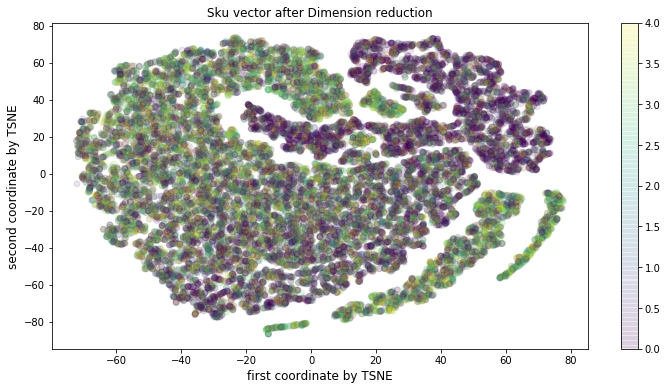

In [78]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=20)

skut = tsne.fit_transform(sku)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(skut[:, 0], skut[:, 1], alpha=0.1, c = c['attribute1'][:-1])
plt.colorbar()
plt.xlabel('first coordinate by TSNE', fontsize=12)
plt.ylabel('second coordinate by TSNE', fontsize=12)
plt.title('Sku vector after Dimension reduction')

Text(0.5, 1.0, 'Sku vector after Dimension reduction')

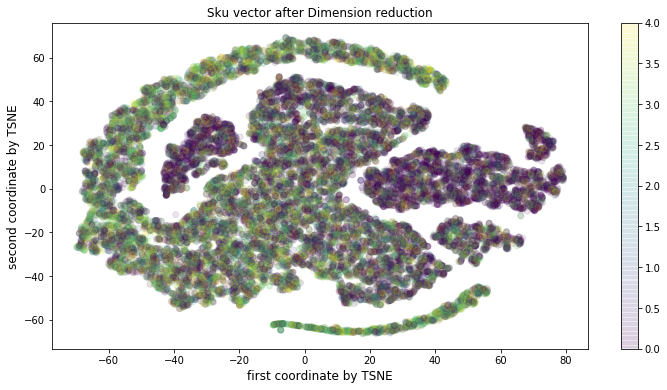

In [86]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40)

skut = tsne.fit_transform(sku)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(skut[:, 0], skut[:, 1], alpha=0.1, c = c['attribute1'][:-1])
plt.colorbar()
plt.xlabel('first coordinate by TSNE', fontsize=12)
plt.ylabel('second coordinate by TSNE', fontsize=12)
plt.title('Sku vector after Dimension reduction')

Text(0.5, 1.0, 'Sku vector after Dimension reduction')

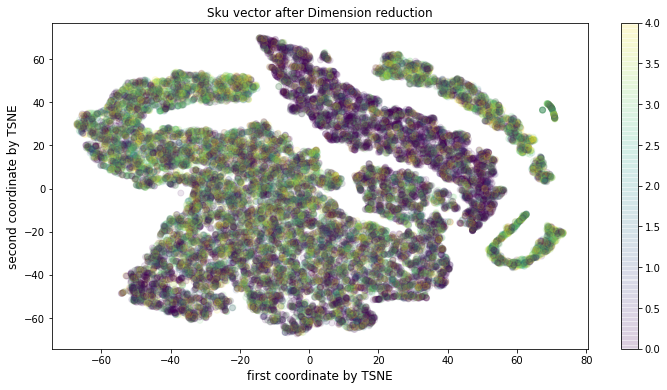

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=45)

skut = tsne.fit_transform(sku)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(skut[:, 0], skut[:, 1], alpha=0.1, c = c['attribute1'][:-1])
plt.colorbar()
plt.xlabel('first coordinate by TSNE', fontsize=12)
plt.ylabel('second coordinate by TSNE', fontsize=12)
plt.title('Sku vector after Dimension reduction')

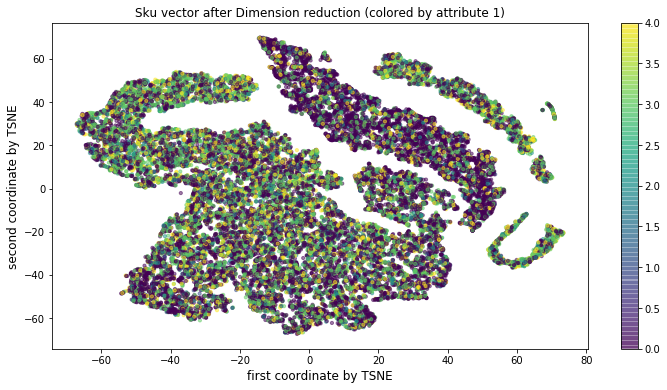

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(skut[:, 0], skut[:, 1], alpha=0.5, c = c['attribute1'][:-1], s=10)
plt.colorbar()
plt.xlabel('first coordinate by TSNE', fontsize=12)
plt.ylabel('second coordinate by TSNE', fontsize=12)
plt.title('Sku vector after Dimension reduction (colored by attribute 1)')
plt.savefig('sku_vector_.png')

Text(0.5, 1.0, 'Sku vector after Dimension reduction')

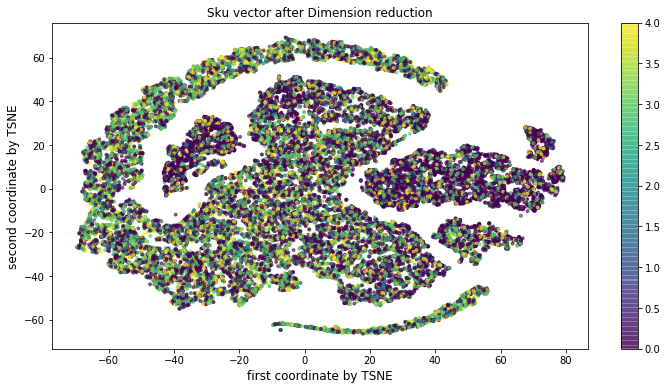

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(skut[:, 0], skut[:, 1], alpha=0.6, c = c['attribute1'][:-1], s=8)
plt.colorbar()
plt.xlabel('first coordinate by TSNE', fontsize=12)
plt.ylabel('second coordinate by TSNE', fontsize=12)
plt.title('Sku vector after Dimension reduction')



In [41]:
df = pd.read_csv('JD_sku_data.csv')
df['label'] = df['sku_ID'].apply(sku_manager.get_label_by_ID)

In [27]:
df.sort_values

,sku_ID,type,brand_ID,attribute1,attribute2,activate_date,deactivate_date,label
21865,000161cd1b,2,0b76f3c8dc,3.0,100.0,NaN,NaN,0
18738,00078c2a0f,2,4240d14733,3.0,60.0,NaN,NaN,1
16030,0009ac56b7,2,9b0d3a5fc6,3.0,60.0,NaN,NaN,2
1652,000aa92b82,2,9d3465eacc,4.0,100.0,NaN,NaN,3
8851,000d4af39d,2,42e6445fca,4.0,100.0,NaN,NaN,4
...,...,...,...,...,...,...,...,...
12511,fff84ed7ec,1,ab56426464,1.0,-,NaN,NaN,32189
5453,fffaaabb99,2,bd97f9a5fa,3.0,100.0,NaN,NaN,32190
3109,fffe1bd280,1,adbd559b78,3.0,70.0,NaN,NaN,32191
2572,fffe6eb4df,2,042c8894a9,3.0,100.0,NaN,NaN,32192


In [63]:
c = color.merge(df, left_on='color', right_on='label', how='outer')

In [72]:
def change(x):
    try:
        return int(x)
    except ValueError:
        return 0


c['type1'] = c['type'].apply(change) * 20

In [70]:
c

,color,sku_ID,type,brand_ID,attribute1,attribute2,activate_date,deactivate_date,label,type1
0,0,000161cd1b,2.0,0b76f3c8dc,3.0,100.0,NaN,NaN,0.0,2
1,1,00078c2a0f,2.0,4240d14733,3.0,60.0,NaN,NaN,1.0,2
2,2,0009ac56b7,2.0,9b0d3a5fc6,3.0,60.0,NaN,NaN,2.0,2
3,3,000aa92b82,2.0,9d3465eacc,4.0,100.0,NaN,NaN,3.0,2
4,4,000d4af39d,2.0,42e6445fca,4.0,100.0,NaN,NaN,4.0,2
...,...,...,...,...,...,...,...,...,...,...
32191,32190,fffaaabb99,2.0,bd97f9a5fa,3.0,100.0,NaN,NaN,32190.0,2
32192,32191,fffe1bd280,1.0,adbd559b78,3.0,70.0,NaN,NaN,32191.0,1
32193,32192,fffe6eb4df,2.0,042c8894a9,3.0,100.0,NaN,NaN,32192.0,2
32194,32193,ffffd456aa,2.0,86a6979f75,0.0,0.0,NaN,NaN,32193.0,2
